# Imports

In [2]:
import pandas as pd
import numpy as np
import keras
import math

Using TensorFlow backend.


# Load the dataset

In [54]:
# one hot encode the dataset, only take 6:00, 12:00 and 18:00 b/c that when most 
# of the times are taken
dataframe = pd.read_csv("atlantic_without_NW.csv")
dataframe["time"] = dataframe["time"].astype('category')
dataframe['date'] = [str(i)[4:6] for i in dataframe['date']] # Get just the month

dataframe = pd.get_dummies(dataframe, columns=["time","rating","date"])
dataframe.drop(["ocean","name"],axis=1, inplace=True)

y = dataframe[["rating_ DB","rating_ EX","rating_ HU","rating_ LO","rating_ SD","rating_ SS","rating_ TD","rating_ TS","rating_ V"]].values

X = dataframe[["lat","long","wind_speed","pressure","time_600","time_1200","time_1800","date_01","date_04","date_05","date_06","date_07","date_08","date_09","date_10","date_11","date_12"]].values



# Clean the data

In [63]:
# delete all the rows that contain no readings for pressure
rows_to_delete = []
row_num = 0

# find rows with bad pressure reading
for row in X:
    if row[3] == -999:
        rows_to_delete.append(row_num)
    row_num += 1

# remove rows with bad pressure reading
X = np.delete(X, rows_to_delete, 0)
y = np.delete(y, rows_to_delete, 0)

# encode lat lng to cartesian mapping
encoded_lat_long = np.zeros(shape=(len(X),3)) # array to hold x,y,z coordinates
count = 0
R = 6371 # radius of earth

for row in X:
    lat = np.deg2rad(row[0])
    lng = np.deg2rad(row[1])

    encoded_lat_long[count][0] = R * (math.cos(lat) * math.cos(lng))
    encoded_lat_long[count][1] = R * (math.cos(lat) * math.sin(lng))
    encoded_lat_long[count][2] = R * math.sin(lat)
    count += 1

# remove old lat lng features
X = np.delete(X, 0, 1)
X = np.delete(X, 0, 1)

# append new cartesian features to featureset
X = np.append(X, encoded_lat_long, axis= 1)


In [64]:
print(X[0])

[2.50000000e+01 1.00900000e+03 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.46581665e+03
 4.98665664e+03 1.92639857e+03]


# Split the dataset into training set and test set

In [65]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


# Train the model on training set

In [66]:
from keras.models import Sequential
from keras.layers import Dense

In [70]:
classifier = Sequential()

# input layer
classifier.add(Dense(output_dim=9, init='uniform', activation='relu', input_dim=18))

# hidden layer
classifier.add(Dense(output_dim=10, init='uniform', activation='relu'))

# hidden layer
classifier.add(Dense(output_dim=14, init='uniform', activation='relu'))

# hidden layer
classifier.add(Dense(output_dim=16, init='uniform', activation='relu'))

# output layer
classifier.add(Dense(output_dim=9, init='uniform', activation='softmax'))

# create the NN
classifier.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

# Predict the test set


In [71]:

history = classifier.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=10,
epochs=200)

=====] - 3s 259us/step - loss: 0.4957 - accuracy: 0.8278 - val_loss: 0.4807 - val_accuracy: 0.8414
Epoch 69/200
12380/12380 [==============================] - 3s 258us/step - loss: 0.4879 - accuracy: 0.8313 - val_loss: 0.4674 - val_accuracy: 0.8404
Epoch 70/200
12380/12380 [==============================] - 3s 272us/step - loss: 0.5003 - accuracy: 0.8258 - val_loss: 0.6113 - val_accuracy: 0.8000
Epoch 71/200
12380/12380 [==============================] - 3s 264us/step - loss: 0.4836 - accuracy: 0.8299 - val_loss: 0.4657 - val_accuracy: 0.8420
Epoch 72/200
12380/12380 [==============================] - 3s 252us/step - loss: 0.5023 - accuracy: 0.8258 - val_loss: 0.5946 - val_accuracy: 0.7968
Epoch 73/200
12380/12380 [==============================] - 5s 372us/step - loss: 0.4983 - accuracy: 0.8271 - val_loss: 0.4746 - val_accuracy: 0.8391
Epoch 74/200
12380/12380 [==============================] - 4s 293us/step - loss: 0.4814 - accuracy: 0.8313 - val_loss: 0.5796 - val_accuracy: 0.7961
E

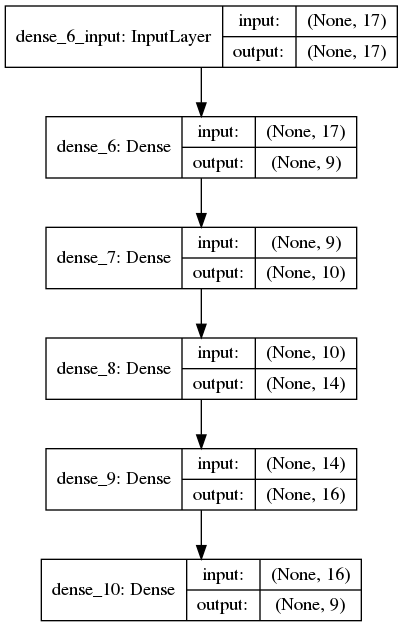

In [62]:
from ann_visualizer.visualize import ann_viz
from keras.utils.vis_utils import plot_model

plot_model(classifier, to_file="hurricane_layer_detail.png", show_shapes=True, show_layer_names=True)
# ann_viz(classifier, title="Hurricane Classifier", filename="hurricane_network")

Text(0.5, 1.0, 'Accuracy of NN with 4 hidden layers and 18 input features')

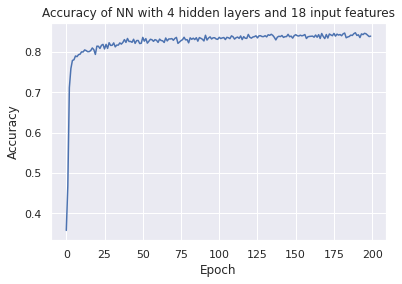

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(history.history['accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy of NN with 4 hidden layers and 18 input features")